# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# Importing libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="tab10")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./data/DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./data/DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Loading data

In [2]:
# # Loading the data
# type_dict = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str}
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=type_dict)
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=type_dict)

# # Writing complete data to pickle files
# azdias.to_pickle("./data/azdias_complete.pkl")  
# customers.to_pickle("./data/customer_complete.pkl")  

# # Creating sample data
# azdias_sample = azdias.sample(int(azdias.shape[0]*0.1))
# customer_sample = customers.sample(int(customers.shape[0]*0.5))

# # Writing sample data to pickle files
# azdias_sample.to_pickle("./data/azdias_sample.pkl")  
# customer_sample.to_pickle("./data/customer_sample.pkl")  

In [3]:
# Reading sample data from pickle files
azdias = pd.read_pickle("./data/azdias_complete.pkl")
customers = pd.read_pickle("./data/customer_complete.pkl")

In [4]:
# Loading dias attributes, that have detailed mapping of data values
list_attributes = pd.read_csv('./data/dias_attributes.csv', header=None).iloc[0,:].tolist()

### Exploring data

**Shape of data and preview**

In [5]:
# Showing number of columns and rows
azdias.shape, customers.shape

((891221, 366), (191652, 369))

In [6]:
# Dropping customers extra columns (not relevant for further steps)
customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [7]:
# Showing number of columns and rows
azdias.shape, customers.shape

((891221, 366), (191652, 366))

In [8]:
# Data Preview
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [9]:
# Data Preview
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4


**Analyzing NaNs**

In [10]:
def nan_histograms(df, df_name):
    """Plotting two histograms for columns and rows of dataframe showing number of NaNs"""
    fig = plt.figure(figsize=(16, 4.5))
    fig.suptitle("NaNs in "+df_name+" data", fontsize=14)
    ax1 = plt.subplot(1,2,1)
    ax1.hist(df.isnull().mean(axis=0)*100, bins=np.linspace(0,100,21))
    ax1.set_xlabel('Percentage of NaNs [%]', fontsize=12, weight='bold')
    ax1.set_ylabel('Number of columns', fontsize=12, weight='bold')
    ax2 = plt.subplot(1,2,2)
    ax2.hist(df.isnull().mean(axis=1)*100, bins=np.linspace(0,100,21))
    ax2.set_xlabel('Percentage of NaNs [%]', fontsize=12, weight='bold')
    ax2.set_ylabel('Number of rows', fontsize=12, weight='bold')

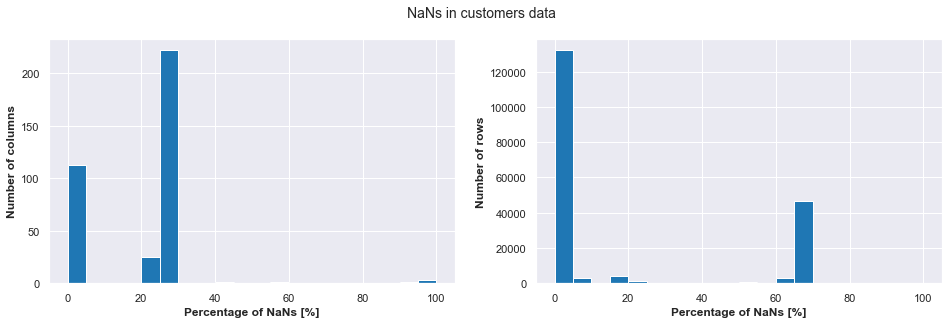

In [11]:
# Plotting customers NaN histogram
nan_histograms(customers, 'customers')

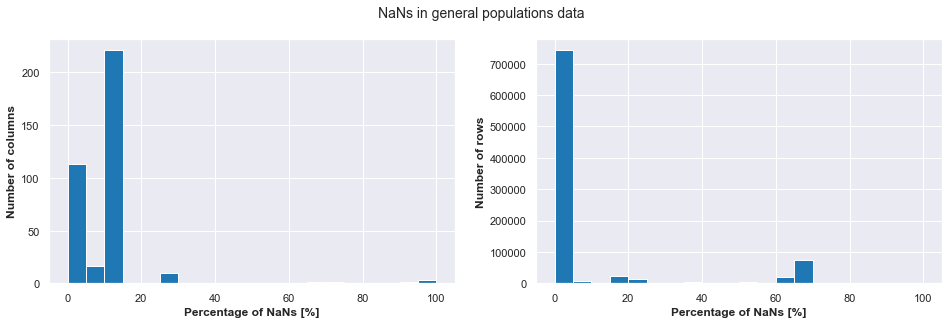

In [12]:
# Plotting general populations NaN histogram
nan_histograms(azdias, 'general populations')

In [13]:
def nan_distribution(df, title):
    """Plotting NaN distribution - INPUT: DataFrame and plot title (string)"""
    x = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False).index
    y = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
    fig = plt.figure(figsize=(16, 4.5))
    ax = plt.subplot(1,1,1)
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('columns', fontsize=12, weight='bold')
    ax.set_ylabel('Percentage of NaNs [%]', fontsize=12, weight='bold')
    ax.bar(x=x, height=y, edgecolor = "none")
    ax.xaxis.set_visible(False)
    plt.axhline(y=30, color='r', linestyle='-')

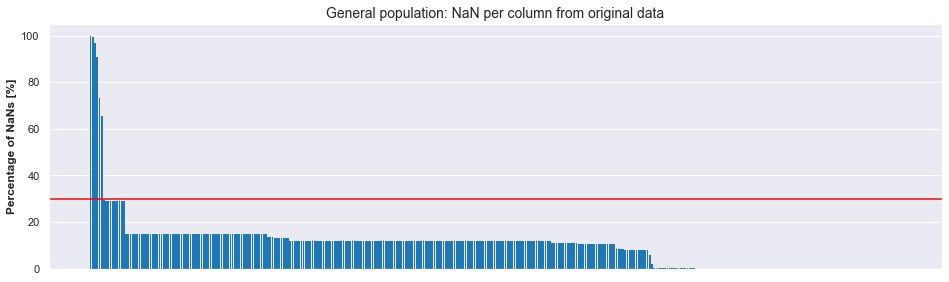

In [14]:
# Plotting general population NaN distribution
nan_distribution(azdias, 'General population: NaN per column from original data')

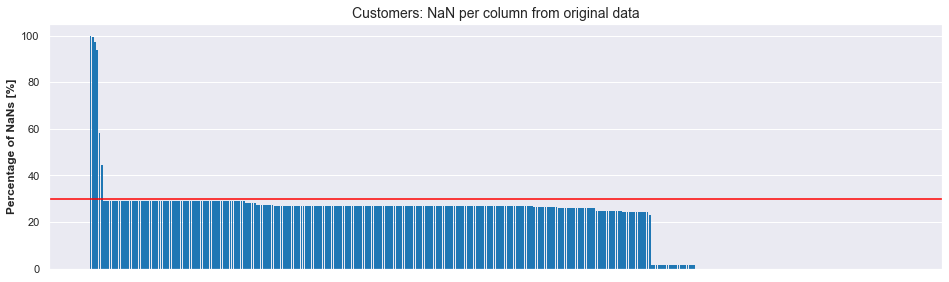

In [15]:
# Plotting customers NaN distribution
nan_distribution(customers, 'Customers: NaN per column from original data')

**Analyzing class distribution**

In [16]:
# Creating DataFrame to compare 'CAMEO_DEUG_2015' of customers and general population data
categories = ['upper class', 'upper middleclass', 'established middleclass', 'consumption-oriented middleclass ',
              'active middleclass ', 'low-consumption middleclass', 'lower middleclass', 'working class',
              'urban working class', 'unknown']
customers_data = customers['CAMEO_DEUG_2015'].value_counts(normalize=True).sort_index()*100
general_pop_data = azdias['CAMEO_DEUG_2015'].value_counts(normalize=True).sort_index()*100
class_cat = pd.DataFrame(data={'customer': customers_data, 'general_population': general_pop_data, 'categorie': categories})
class_cat = pd.melt(class_cat, id_vars=['categorie'], value_vars=['customer', 'general_population'], ignore_index=False)

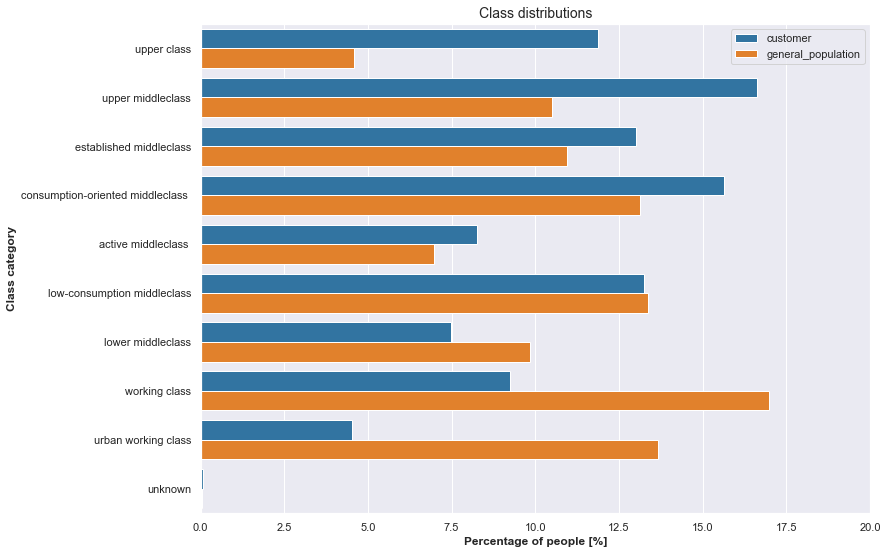

In [17]:
# Plotting class distributions based on 'CAMEO_DEUG_2015'
fig = plt.figure(figsize=(12, 9))
ax = sns.barplot(x="value", y="categorie", hue="variable", data=class_cat, orient='h')
plt.title('Class distributions', fontsize=14)
ax.set_xlabel('Percentage of people [%]', fontsize=12, weight='bold')
ax.set_ylabel('Class category', fontsize=12, weight='bold')
ax.set_xlim([0, 20])
plt.legend(loc='upper right');

### Cleaning data

I manually created three lists for replacing unknown values with nan based on __*DIAS Information Levels - Attributes 2017.xlsx*__ and __*DIAS Attributes - Values 2017.xlsx*__.


In [18]:
# List of columns, where "0" means "unknown"
list_unknown_0 = pd.read_csv('./data/attributes_unknown_0.csv', header=None).iloc[0,:].tolist()

# List of columns, where "9" means "unknown"
list_unknown_9 = pd.read_csv('./data/attributes_unknown_9.csv', header=None).iloc[0,:].tolist()

# List of columns, where "10" means "unknown"
list_unknown_10 = pd.read_csv('./data/attributes_unknown_10.csv', header=None).iloc[0,:].tolist()

print(f"For {len(list_unknown_0)+len(list_unknown_9)+len(list_unknown_10)} attributes unknown values can be replaced by NaN.")

For 150 attributes unknown values can be replaced by NaN.


In [19]:
def cleaning_data(df, test_data=False):
    """Performing several cleaning steps:
    - Converting data types
    - Renaming columns
    - Replacing unknown/invalid values with NaN
    - Dropping columns with high NaN percentage
    - Dropping rows with high NaN percentage
    - Filling NaNs of numerical values with columns median
    - Filling NaNs of categorical values with columns mode
    - Dummy categorical columns
    
    INPUT:
    - DataFrame
    - test_data (bool) - if test_data=True columns/rows with high NaN were not dropped
    OUTPUT:
    - Clean DataFrame
    - DataFrame after filling with NaNs and before dropping columns/rows
    
    """
    # Creating a copy of DataFrame
    df = df.copy()

    # Converting int64 columns to int32 for reducing memory usage
    for col in customers.select_dtypes(np.int64).columns:
        customers[col] = customers[col].astype(np.int32)   
    
    # Converting float columns to int32 for reducing memory usage
    # There are no decimal places other than 0
    for col in customers.select_dtypes(include=['float']).columns:
        customers[col] = customers[col].replace(np.nan, -1)
        customers[col] = customers[col].astype(np.int32)   

    # Creating dictionary for renaming column names
    dict_new_columns = {}
    for attribute in set(list_attributes)-set(df.columns):
        if attribute[0:3] == 'D19' and attribute[-3:] == '_RZ':
            dict_new_columns[attribute[:-3]] = attribute
    dict_new_columns['CAMEO_INTL_2015'] = 'CAMEO_DEUINTL_2015'
    dict_new_columns['D19_BUCH_CD'] = 'D19_BUCH_RZ'
    dict_new_columns['KK_KUNDENTYP'] = 'D19_KK_KUNDENTYP'

    # Renaming column names
    df.rename(columns=dict_new_columns, inplace=True)
   
    # Replacing 0 values (means "unknown") in every column of list "list_unknown_0" with NaN
    for col in list_unknown_0:
        df.loc[:,col] = df.loc[:,col].replace(0, np.nan)
        
    # Replacing 9 values (means "unknown") in every column of list "list_unknown_9" with NaN
    for col in list_unknown_9:
        df.loc[:,col] = df.loc[:,col].replace(9, np.nan)
    
    # Replacing 10 values (means "unknown") in every column of list "list_unknown_10" with NaN
    for col in list_unknown_10:
        df.loc[:,col] = df.loc[:,col].replace(10, np.nan)
    
    # Replacing -1 values (means "unknown") in every column" with NaN
    for col in df.columns:
        df[col] = df[col].replace(-1, np.nan)
    
    # Replacing 'XX' values (means "unknown") in "CAMEO_DEUINTL_2015" column with NaN
    df.loc[:,'CAMEO_DEUINTL_2015'] = df.loc[:,'CAMEO_DEUINTL_2015'].replace('XX', np.nan)
    
    # Replacing 'X' values (means "unknown") in "CAMEO_DEUG_2015" column with NaN
    df.loc[:,'CAMEO_DEUG_2015'] = df.loc[:,'CAMEO_DEUG_2015'].replace('X', np.nan)
    
    # Replacing 'D19_UNBEKANNT' values (means "unknown") in "D19_LETZTER_KAUF_BRANCHE" column with NaN
    df.loc[:,'D19_LETZTER_KAUF_BRANCHE'] = df.loc[:,'D19_LETZTER_KAUF_BRANCHE'].replace('D19_UNBEKANNT', np.nan)
    
    # Data type conversions
    df['CAMEO_DEUINTL_2015'] = pd.to_numeric(df['CAMEO_DEUINTL_2015'], errors='coerce')
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], errors='coerce')
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    
    # Extracting year of date column and dropping it
    df['EINGEFUEGT_JAHR'] = pd.to_numeric(df['EINGEFUEGT_AM'].dt.year, downcast='integer', errors='coerce')
    df.drop('EINGEFUEGT_AM', axis=1, inplace=True)

    # Saving DataFrame filled with NaNs
    df_nan = df.copy()
    
    if test_data==False:
        # Dropping 'LNR' column, because these are just record numbers
        # Dropping 'CAMEO_DEU_2015':
        # - categorical variable with 44 distinct values
        # - redundant to and more complex than 'CAMEO_DEUINTL_2015' and 'CAMEO_DEUG_2015'
        # Dropping 'D19_LETZTER_KAUF_BRANCHE', because has more than 40% missing values,
        # but somehow won't be dropped by algorithm below
        df.drop(['LNR', 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)
        
        # Dropping columns with more than 33% of NaNs (row need 67% of non-NaN-values to survive)
        df.dropna(axis=1, thresh=int(round(df.shape[0]*0.7)), inplace=True)

        # Dropping rows with more than 33% of NaNs (row need 67% of non-NaN-values to survive)
        df.dropna(axis=0, thresh=int(round(df.shape[1]*0.7)), inplace=True)

    # Filling NaNs of numeric columns with the median
    num_columns = df.select_dtypes(np.number).columns
    for col in num_columns:
        df[col].fillna((df[col].median()), inplace=True)
   
    # Filling NaNs of categorical columns with the mode
    cat_columns = df.select_dtypes(include=['object']).columns
    for col in cat_columns:
        df[col].fillna((df[col].mode()[0]), inplace=True)
 
    # Dummy the categorical variables
    for col in cat_columns:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
  
    return df, df_nan

In [20]:
# Cleaning DataFrames
azdias_clean, azdias_nan = cleaning_data(azdias)
customers_clean, customers_nan = cleaning_data(customers)

In [21]:
# Analyzing clean data
print(azdias_clean.shape, customers_clean.shape)
print(azdias_clean.isnull().sum().sum(), customers_clean.isnull().sum().sum())

(785293, 294) (140351, 292)
0 0


In [22]:
# Selecting columns that remain in both datasets
col_intersect = np.intersect1d(customers_clean.columns, azdias_clean.columns)
azdias_clean = azdias_clean[col_intersect]
customers_clean = customers_clean[col_intersect]
print(azdias_clean.shape, customers_clean.shape)

(785293, 292) (140351, 292)


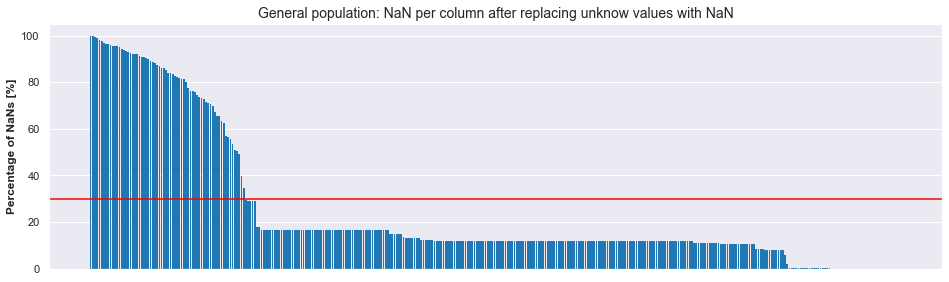

In [23]:
# Plotting general population NaN distribution
nan_distribution(azdias_nan, 'General population: NaN per column after replacing unknow values with NaN')

In [24]:
increase_nan_azdias = round((azdias_nan.isnull().sum().sum()/azdias.isnull().sum().sum()-1)*100,1)
print(f"{increase_nan_azdias}% increase of NaN values compared to original data.")

136.3% increase of NaN values compared to original data.


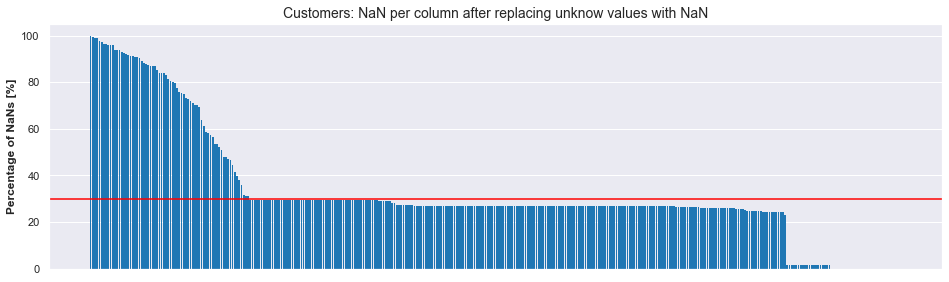

In [25]:
# Plotting customers NaN distribution
nan_distribution(customers_nan, 'Customers: NaN per column after replacing unknow values with NaN')

In [26]:
customers_nan_azdias = round((customers_nan.isnull().sum().sum()/customers.isnull().sum().sum()-1)*100,1)
print(f"{customers_nan_azdias}% increase of NaN values compared to original data.")

7612.0% increase of NaN values compared to original data.


In [27]:
# Data preview after cleaning
azdias_clean.head(2)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
1,9.0,21.0,1,2,11.0,0.0,0.0,2.0,12.0,0.0,...,2.0,0.0,4.0,8.0,11.0,10.0,9.0,4.0,3.0,5
2,9.0,17.0,3,2,10.0,0.0,0.0,1.0,7.0,0.0,...,1.0,0.0,2.0,9.0,9.0,6.0,9.0,2.0,3.0,5


In [28]:
# Data preview after cleaning
customers_clean.head(2)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,1.0,10.0,4,1,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,3.0,5.0,3.0,2.0,9.0,7.0,6.0,3
2,1.0,0.0,4,2,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,0.0,4.0,10.0,13.0,11.0,9.0,2.0,6.0,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

In [30]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785293 entries, 1 to 891220
Columns: 292 entries, AKT_DAT_KL to ZABEOTYP
dtypes: float64(260), int64(31), uint8(1)
memory usage: 1.7 GB


In [32]:
# Scaling general population data for PCA
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean.astype(float))
customers_scaled = scaler.fit_transform(customers_clean.astype(float))

In [33]:
# Instantiating PCA
pca = PCA()

# Fitting and transforming data
azdias_pca = pca.fit_transform(azdias_scaled)

In [34]:
def plot_explained_variance(pca):
    """Plotting (cumulative) explained variance"""
    n_components = range(1,len(pca.explained_variance_ratio_)+1)
    
    fig = plt.figure(figsize=(16, 4.5))
    
    ax1 = plt.subplot(1,2,1)
    ax1.plot(n_components, pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
    ax1.set_title('Cumulative explained variance by components', fontsize=14)
    ax1.set_xlabel('Number of components', fontsize=12, weight='bold')
    ax1.set_ylabel('Variance', fontsize=12, weight='bold')
    
    ax2 = plt.subplot(1,2,2)
    ax2.bar(n_components, pca.explained_variance_ratio_, edgecolor = "none")
    ax2.set_title('Explained variance by components', fontsize=14)
    ax2.set_xlabel('Number of components', fontsize=12, weight='bold')
    ax2.set_ylabel('Variance', fontsize=12, weight='bold')

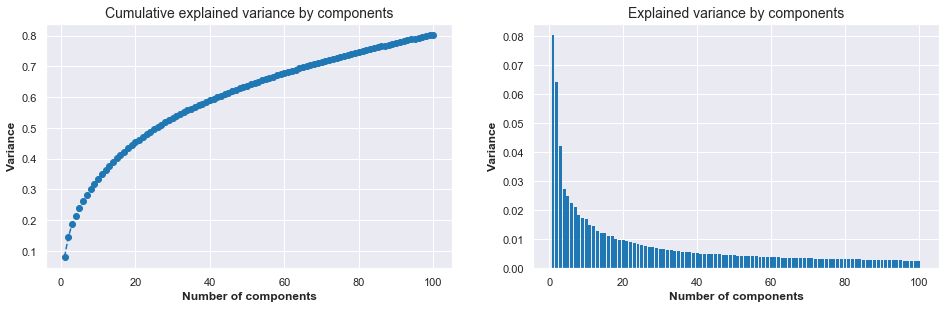

In [39]:
# Plotting explained variance of general population
plot_explained_variance(pca)

In [40]:
print(f"Number of components < 80%: {np.sum(pca.explained_variance_ratio_.cumsum()<0.8)}")

Number of components < 80%: 98


**In order to preserve about 80 % of the variance, we choose to keep 100 components.**

In [41]:
# Instantiating PCA
pca = PCA(n_components = 100)

# Fitting and transforming data
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.fit_transform(customers_scaled)

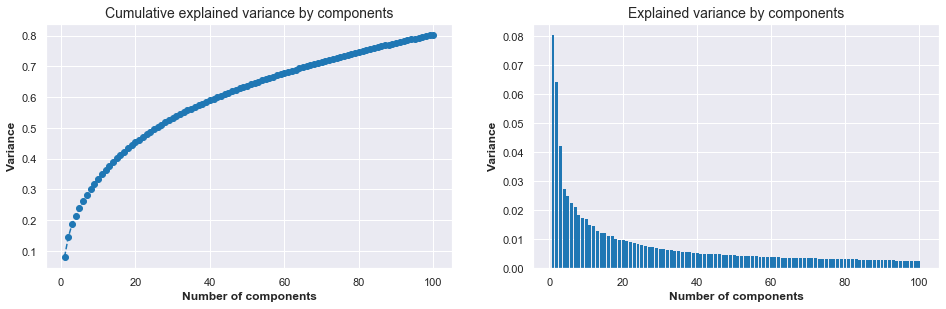

In [42]:
# Plotting explained variance of general population
plot_explained_variance(pca)

### Clustering

#### Identify number of clusters

In [44]:
def calculate_k_means_wcss(data, n_cluster_max, plot=True):
    """Calculating Within Cluster Sums of Squares (WCSS) with KMeans
    INPUT:
    - data
    - n_cluster_max (int): maximum number of clusters
    - plot (bool): Plotting Sum of squared distances if True
    
    OUTPUT: None
    """
    n_cluster = np.arange(2,n_cluster_max+1)
    wcss = [MiniBatchKMeans(n, batch_size=3072).fit(data).score(data) for n in n_cluster]
    
    if plot:
        plt.figure(figsize=(8,4.5))
        plt.plot(n_cluster, np.abs(wcss), marker = 'o', linestyle = '--')
        plt.title('Sum of squared distances', fontsize=14)
        plt.xlabel('Number of clusters', fontsize=12, weight='bold')
        plt.ylabel('WCSS', fontsize=12, weight='bold')
        plt.show()

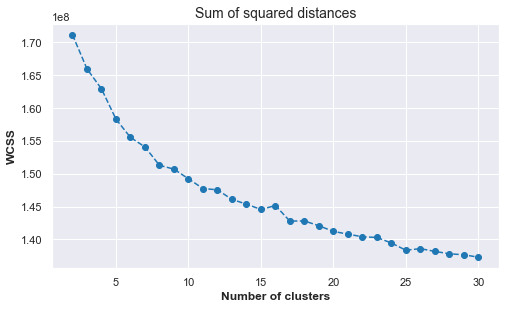

In [45]:
# Plotting Sum of squared distances of general population data
calculate_k_means_wcss(azdias_pca, 30, plot=True)

**Using the elbow-method we choose to continue clustering with 12 clusters.**

In [46]:
# Calculating K-Means of general population data
kmeans = KMeans(n_clusters = 12, random_state=2)

# Compute cluster centers and predict cluster index for each sample
kmeans_azdias = kmeans.fit_predict(azdias_pca)
kmeans_customers = kmeans.fit_predict(customers_pca)

In [47]:
kmeans_azdias.shape, kmeans_customers.shape

((785293,), (140351,))

In [48]:
(unique_azdias, counts_azdias) = np.unique(kmeans_azdias, return_counts=True)
(unique_customers, counts_customers) = np.unique(kmeans_customers, return_counts=True)

In [49]:
df = pd.DataFrame([counts_azdias/kmeans_azdias.shape[0], counts_customers/kmeans_customers.shape[0]]).transpose()
df.rename(columns={0: 'general_population', 1: 'customers'}, inplace=True)
df['cluster'] = np.arange(1,df.shape[0]+1)
df = pd.melt(df, id_vars=['cluster'], value_vars=['customers', 'general_population'], ignore_index=False)

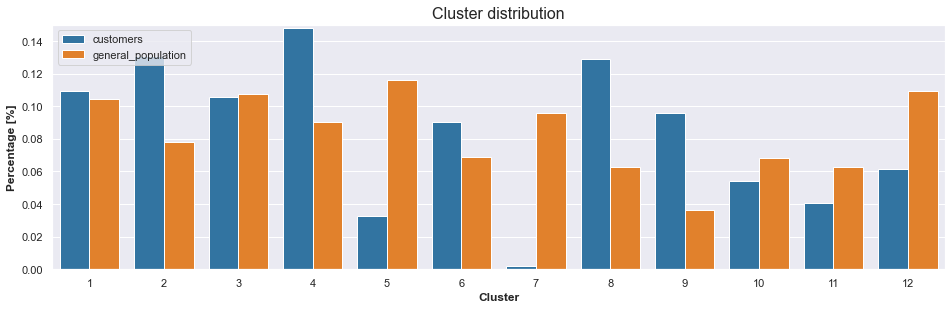

In [51]:
# Plotting class distributions based on 'CAMEO_DEUG_2015'
fig = plt.figure(figsize=(16, 4.5))
ax = sns.barplot(x="cluster", y="value", hue="variable", data=df, orient='v')
plt.title('Cluster distribution', fontsize=16)
ax.set_xlabel('Cluster', fontsize=12, weight='bold')
ax.set_ylabel('Percentage [%]', fontsize=12, weight='bold')
ax.set_ylim([0, .15])
plt.legend(loc='upper left');

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [29]:
# Reading training data from pickle files
mailout_train = pd.read_pickle("./data/mailout_train.pkl")
mailout_test = pd.read_pickle("./data/mailout_test.pkl")

In [30]:
# Showing number of columns and rows
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

In [31]:
# Data preview
mailout_train.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [32]:
print(f"There are {mailout_train['RESPONSE'].isnull().sum()} rows with no Response value.")

There are 0 rows with no Response value.


In [33]:
print(f"Negative Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[0]}")
print(f"Positive Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[1]}")

Negative Response: 0.9876169638284996
Positive Response: 0.012383036171500396


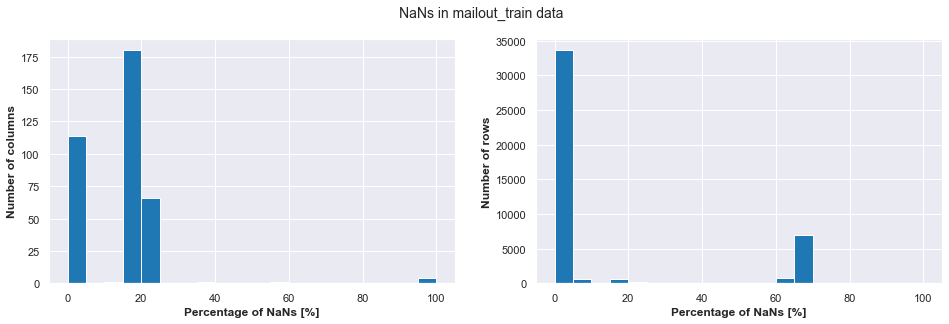

In [34]:
# Plotting NaN histogram of mailout_train data
nan_histograms(mailout_train, 'mailout_train')

In [35]:
# Cleaning DataFrame
mailout_train_clean, mailout_train_nan = cleaning_data(mailout_train)

In [36]:
# Analyzing clean data
print(mailout_train_clean.shape)
print(mailout_train_clean.isnull().sum().sum())

(34998, 296)
0


In [37]:
print(f"Negative Response: {mailout_train_clean['RESPONSE'].value_counts(normalize=True)[0]}")
print(f"Positive Response: {mailout_train_clean['RESPONSE'].value_counts(normalize=True)[1]}")

Negative Response: 0.9875707183267616
Positive Response: 0.01242928167323847


In [38]:
# Create y as the Response column
y_train = mailout_train_clean['RESPONSE']

# Drop Response column
X_train = mailout_train_clean.drop('RESPONSE', axis=1, inplace=False)

**Unscaled Data**

In [39]:
random_state = 2

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=2): 0.6827017785727738
Mean cross_val_score RandomForestClassifier(random_state=2): 0.6411032873663419
Mean cross_val_score GradientBoostingClassifier(random_state=2): 0.7746387812115814


**StandardScaler()**

In [54]:
random_state = 2

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=2): 0.6842794014783573
Mean cross_val_score RandomForestClassifier(random_state=2): 0.6380775601973547
Mean cross_val_score GradientBoostingClassifier(random_state=2): 0.7746299447186968


**MinMaxScaler()**

In [55]:
random_state = 2

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=2): 0.6957241468992594
Mean cross_val_score RandomForestClassifier(random_state=2): 0.6401658154895459
Mean cross_val_score GradientBoostingClassifier(random_state=2): 0.7746339790719682


**From the three models Gradient Boosting Classifier has highest scores. Within Gradient Boosting there is not much difference in scores regarding scaling of data. Therefore we continue without scaling the data.**

In [ ]:
%%time
random_state = 2

parameters = {
    'loss': ['deviance', 'exponential'], # default: 'deviance'
    'learning_rate': [0.01, 0.05, 0.1, 0.15], # default: 0.1
    'n_estimators': [64, 100], # default: 100
    'max_depth': [1, 2, 3, 4], # default: 3
    'min_samples_split': [2, 3], # default: 1
    'max_features': ['sqrt', 'log2'], # default: None 
    'random_state': [random_state]
}

GB = GradientBoostingClassifier()

clf = GridSearchCV(GB, parameters, scoring = 'roc_auc')
clf.fit(X_train, y_train)

In [ ]:
# Getting best score
clf.best_score_

In [ ]:
# Printing best parameters
clf.best_params_

In [ ]:
GB_best = clf.best_estimator_
GB_best.fit(X_train, y_train)

**Feature importances**

In [ ]:
# Analyzing the most important features of the model
feature_importances = pd.DataFrame({'feature_importance':GB_best.feature_importances_}, index=X_train.columns)
fig = plt.figure(figsize=(8, 4.5))
feature_importances.sort_values(by=['feature_importance'], ascending=True).tail(10).plot(kind='barh');

In [ ]:
# Analyzing the most important feature of the model: 'D19_SOZIALES'
mailout_resp_0 = mailout_train[mailout_train['RESPONSE']==0]['D19_SOZIALES'].value_counts(normalize=True).sort_index()
mailout_resp_1 = mailout_train[mailout_train['RESPONSE']==1]['D19_SOZIALES'].value_counts(normalize=True).sort_index()

# Plotting distribution for Response 0 and 1
fig = plt.figure(figsize=(16, 4.5))
ax1 = plt.subplot(1,2,1);
ax1.bar(mailout_resp_0.index, mailout_resp_0*100);
ax1.set_title('Distribution of D19_SOZIALES: Response 0', fontsize=14);
ax1.set_ylim(0,100)
ax1.set_xlabel('value', fontsize=12, weight='bold')
ax1.set_ylabel('Percentage [%]', fontsize=12, weight='bold')
ax2 = plt.subplot(1,2,2);
ax2.bar(mailout_resp_1.index, mailout_resp_1*100);
ax2.set_title('Distribution of D19_SOZIALES: Response 1', fontsize=14);
ax2.set_ylim(0,100)
ax2.set_xlabel('value', fontsize=12, weight='bold')
ax2.set_ylabel('Percentage [%]', fontsize=12, weight='bold');

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# Reading test data from pickle files
mailout_test = pd.read_pickle("./data/mailout_test.pkl")
mailout_test.shape

In [ ]:
# Cleaning test data and selecting same columns like in training data
X_test, X_test_nan = cleaning_data(mailout_test, test_data=True)
X_test = X_test.loc[:,X_train.columns.to_list()]
X_test.shape

In [ ]:
# Predicting response probability
y_pred = GB_best.predict_proba(X_test)

In [ ]:
# Creating Response DataFrame
kaggle = pd.DataFrame(index=mailout_test['LNR'], data=y_pred[:,0])
kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle

In [ ]:
# Saving results to CSV file for Kaggle submission
kaggle.to_csv('./data/kaggle_sub.csv')